In [18]:
from collections import OrderedDict
import gc
from pathlib import Path
import pickle
import sys
sys.path.append('..')
from typing import Dict, List, Tuple, Union, Literal
import warnings
import joblib
import lightgbm as lgb
import numpy as np
import optuna
import pandas as pd
import polars as pl
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedGroupKFold, train_test_split

gc.enable()

In [19]:
KAGGLE = False
MODE:Literal['train', 'test'] = 'train'

In [20]:
if KAGGLE:
    COMPETITION_DIR = Path('/kaggle/input/home-credit-credit-risk-model-stability')
    MODEL_DIR = Path('/kaggle/input/240407-home-credit-test-submit')
    FEATURE_DTYPE_DIR = Path('/kaggle/input/home-credit-enhanced-feature-definitions')
else:
    COMPETITION_DIR = Path('../../data/inputs')
    MODEL_DIR = Path('../../data/models/lgbm-group-tune')
    if not MODEL_DIR.exists():
        MODEL_DIR.mkdir(parents=True)
        MODEL_DIR.joinpath('encoders').mkdir()
        print(MODEL_DIR, 'created')
    FEATURE_DTYPE_DIR = Path('../../data/configs/feature_definitions_dtypes_tables.parquet')

In [21]:
df_features = pd.read_parquet(FEATURE_DTYPE_DIR)
display(df_features)

bool_features = df_features.query('dtype == "Boolean"')
float64_features = df_features.query('dtype == "Float64"')
string_features = df_features.query('dtype == "String"')
date_features = df_features.query('dtype == "Date"')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bool_features['cast_dtype'] = pl.Boolean
    float64_features['cast_dtype'] = pl.Float32
    string_features['cast_dtype'] = pl.String

cast_features = pd.concat([bool_features, float64_features, string_features])
display(cast_features)

,Variable,Description,dtype,tables
0,actualdpd_943P,Days Past Due (DPD) of previous contract (actu...,Float64,"[train_applprev_1_0, train_applprev_1_1]"
1,actualdpdtolerance_344P,DPD of client with tolerance.,Float64,"[train_static_0_0, train_static_0_1]"
2,addres_district_368M,District of the person's address.,String,[train_person_2]
3,addres_role_871L,Role of person's address.,String,[train_person_2]
4,addres_zip_823M,Zip code of the address.,String,[train_person_2]
...,...,...,...,...
460,totinstallast1m_4525188A,Total amount of monthly instalments paid in th...,Float64,"[train_static_0_0, train_static_0_1]"
461,twobodfilling_608L,Type of application process.,String,"[train_static_0_0, train_static_0_1]"
462,type_25L,Contact type of a person.,String,[train_person_1]
463,typesuite_864L,Persons accompanying the client during the loa...,String,"[train_static_0_0, train_static_0_1]"


,Variable,Description,dtype,tables,cast_dtype
78,contaddr_matchlist_1032L,Indicates whether the contact address is found...,Boolean,[train_person_1],Boolean
79,contaddr_smempladdr_334L,Indicates whether the contact address is the s...,Boolean,[train_person_1],Boolean
174,equalitydataagreement_891L,Flag indicating sudden changes in client's soc...,Boolean,"[train_static_0_0, train_static_0_1]",Boolean
175,equalityempfrom_62L,Flag indicating a sudden change in the client'...,Boolean,"[train_static_0_0, train_static_0_1]",Boolean
219,isbidproduct_1095L,Flag indicating if the product is a cross-sell.,Boolean,"[train_static_0_0, train_static_0_1]",Boolean
...,...,...,...,...,...
444,subjectroles_name_541M,Name of subject role in closed credit contract...,String,"[train_credit_bureau_a_2_0, train_credit_burea...",String
445,subjectroles_name_838M,Name of subject role in active credit contract...,String,"[train_credit_bureau_a_2_0, train_credit_burea...",String
461,twobodfilling_608L,Type of application process.,String,"[train_static_0_0, train_static_0_1]",String
462,type_25L,Contact type of a person.,String,[train_person_1],String


In [22]:
def get_depth_paths(load_dir: Path, prefix: Literal['test', 'train']):
    
    assert prefix in ['test', 'train']
    
    depth_paths = OrderedDict()

    depth_paths['static_0'] = []
    depth_paths['static_cb_0'] = []
    depth_paths['applprev_1'] = []
    depth_paths['other_1'] = []
    depth_paths['tax_registry_a_1'] = []
    depth_paths['tax_registry_b_1'] = []
    depth_paths['tax_registry_c_1'] = []
    depth_paths['credit_bureau_a_1'] = []
    depth_paths['credit_bureau_b_1'] = []
    depth_paths['deposit_1'] = []
    depth_paths['person_1'] = []
    depth_paths['debitcard_1'] = []
    depth_paths['applprev_2'] = []
    depth_paths['person_2'] = []
    depth_paths['credit_bureau_a_2'] = []
    depth_paths['credit_bureau_b_2'] = []

    for k in depth_paths.keys():
        depth_paths[k] = sorted(
            [p for p in load_dir.joinpath(f'parquet_files/{prefix}').glob(f'{prefix}_{k}*.parquet')]
        )
    return depth_paths

In [23]:
depth_paths = get_depth_paths(COMPETITION_DIR, MODE)

print(f'the number of {MODE} paths: {sum(len(v1) for v1 in depth_paths.values())}')

the number of train paths: 31


In [24]:
def process_D_features(data: pl.DataFrame, D_columns: List[str]):
    for col in D_columns:
        data = data.with_columns(
            pl.col(col)
            .fill_null('0000-00-00')
            .str.split_exact('-', n=2)
            .struct.rename_fields(['year_' + col, 'month_' + col, 'day_' + col])
            .cast(pl.Int16)
            .alias('fields')
        )
        data = data.drop(col).unnest('fields')
    return data

In [25]:
def merge_dataset(
        base_data: pl.DataFrame,
        depth_paths: Dict[str, List[Path]],
        bool_features: pd.DataFrame,
        float64_features: pd.DataFrame,
        string_features: pd.DataFrame,
        depth: Literal['0', '1', '2', '012'],
    ) -> pd.DataFrame:
    
    assert depth in ['0', '1', '2', '012']
    
    for i, (k, path_list) in enumerate(depth_paths.items()):
        
        if depth == '012':
            pass
        elif depth != k[-1]:
            continue
            
        print(f'loading `{k}`')
        depth_data = []
        for p in path_list:
            sub_data = pl.read_parquet(p).cast({'case_id': pl.Int64})
            if k[-1] == '1':
                sub_data = sub_data.drop('num_group1').group_by('case_id').max().sort('case_id')
            elif k[-1] == '2':
                sub_data = sub_data.drop(['num_group1', 'num_group2']).group_by('case_id').max().sort('case_id')
                
            depth_data.append(sub_data)
            
            print(f'\t{p.stem}: {sub_data.shape}')
            
            del sub_data
            gc.collect()
        
        depth_data = pl.concat(depth_data, how='vertical_relaxed')
        base_data = base_data.join(depth_data, how='left', on='case_id', suffix=f'_{i}')
        
        del depth_data
        gc.collect()
    
    '''
    cast dtypes
    '''
    for _, row in bool_features[['Variable', 'cast_dtype']].iterrows():
        col = row['Variable']
        cast_dtype = row['cast_dtype']
        if col in base_data.columns:
            base_data = base_data.with_columns(pl.col(col).fill_null(np.nan).cast(cast_dtype))
        
    for _, row in float64_features[['Variable', 'cast_dtype']].iterrows():
        col = row['Variable']
        cast_dtype = row['cast_dtype']
        if col in base_data.columns:
            base_data = base_data.with_columns(pl.col(col).cast(cast_dtype))
            
    for _, row in string_features[['Variable', 'cast_dtype']].iterrows():
        col = row['Variable']
        cast_dtype = row['cast_dtype']
        if col in base_data.columns:
            base_data = base_data.with_columns(pl.col(col).cast(cast_dtype))
    
    '''
    process D features
    '''
    D_features = [col for col in base_data.columns if col[-1] == 'D']
    base_data = process_D_features(base_data, D_features)
    base_data = base_data.to_pandas()
    return base_data


def encode(depth_data:pd.DataFrame, mode:Literal['train', 'test'], save_dir:Path) -> pd.DataFrame:

    assert mode in ['train', 'test']

    object_columns = depth_data.dtypes.index[depth_data.dtypes==object].to_list()
    if 'date_decision' in object_columns:
        object_columns.remove('date_decision')

    if mode == 'train':
        object_data = []
        print(f'num of object columns: {len(object_columns)}')
        for col in object_columns:
            encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            encoder.fit(depth_data[col].values.reshape(-1, 1))
            # save encoder as joblib
            save_path = save_dir.joinpath(f'encoder_{col}.joblib')
            joblib.dump(encoder, save_path)
            object_data.append(encoder.transform(depth_data[col].values.reshape(-1, 1)).astype(np.float32))
        depth_data.drop(columns=object_columns, inplace=True)
        print(f'num of object columns: {len(object_data)}')
        object_data = np.concatenate(object_data, axis=1)
        object_data = pd.DataFrame(object_data, columns=object_columns)
    else:
        object_data = []
        for col in object_columns:
            # load encoder
            load_path = save_dir.joinpath(f'encoder_{col}.joblib')
            encoder = joblib.load(load_path)
            object_data.append(encoder.transform(depth_data[col].values.reshape(-1, 1)).astype(np.float32))
        depth_data.drop(columns=object_columns, inplace=True)
        object_data = np.concatenate(object_data, axis=1)
        object_data = pd.DataFrame(object_data, columns=object_columns)

    return pd.concat([depth_data, object_data], axis=1)


In [26]:
base_data = pl.read_parquet(
    COMPETITION_DIR.joinpath(f'parquet_files/{MODE}/{MODE}_base.parquet')
).cast(
    {
        'case_id': pl.Int64,
        'date_decision': pl.String,
        'MONTH': pl.Int64,
        'WEEK_NUM': pl.Int64,
    }
)

print(MODE)
display(base_data)

train


case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1
…,…,…,…,…
2703450,"""2020-10-05""",202010,91,0
2703451,"""2020-10-05""",202010,91,0
2703452,"""2020-10-05""",202010,91,0


In [27]:
depth_data = merge_dataset(
    base_data,
    depth_paths,
    bool_features,
    float64_features,
    string_features,
    '012'
)
display(depth_data)

loading `static_0`
	train_static_0_0: (1003757, 168)
	train_static_0_1: (522902, 168)
loading `static_cb_0`
	train_static_cb_0: (1500476, 53)
loading `applprev_1`
	train_applprev_1_0: (782997, 40)
	train_applprev_1_1: (438525, 40)
loading `other_1`
	train_other_1: (51109, 6)
loading `tax_registry_a_1`
	train_tax_registry_a_1: (457934, 4)
loading `tax_registry_b_1`
	train_tax_registry_b_1: (150732, 4)
loading `tax_registry_c_1`
	train_tax_registry_c_1: (482265, 4)
loading `credit_bureau_a_1`
	train_credit_bureau_a_1_0: (335275, 78)
	train_credit_bureau_a_1_1: (549263, 78)
	train_credit_bureau_a_1_2: (325127, 78)
	train_credit_bureau_a_1_3: (176608, 78)
loading `credit_bureau_b_1`
	train_credit_bureau_b_1: (36500, 44)
loading `deposit_1`
	train_deposit_1: (105111, 4)
loading `person_1`
	train_person_1: (1526659, 36)
loading `debitcard_1`
	train_debitcard_1: (111772, 5)
loading `applprev_2`
	train_applprev_2: (1221522, 4)
loading `person_2`
	train_person_2: (1435105, 9)
loading `credit_bu

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,...,day_empl_employedfrom_271D,year_openingdate_857D,month_openingdate_857D,day_openingdate_857D,year_empls_employedfrom_796D,month_empls_employedfrom_796D,day_empls_employedfrom_796D,year_pmts_date_1107D,month_pmts_date_1107D,day_pmts_date_1107D
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.599976,0.000000,0.0,...,15,0,0,0,0,0,0,0,0,0
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.000000,0.000000,0.0,...,29,0,0,0,0,0,0,0,0,0
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.000000,0.000000,0.0,...,15,0,0,0,0,0,0,0,0,0
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.600098,0.000000,0.0,...,15,0,0,0,0,0,0,0,0,0
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.199951,0.000000,0.0,...,15,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.359375,3675.400146,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.468750,7088.600098,6191.600098,0.0,...,0,0,0,0,0,0,0,0,0,0
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.400391,7788.800293,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.578125,1195.400024,2827.199951,0.0,...,0,2015,5,29,0,0,0,0,0,0


In [28]:
depth_data = encode(depth_data, MODE, MODEL_DIR.joinpath('encoders'))
display(depth_data)

num of object columns: 99
num of object columns: 99


,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,...,conts_role_79M,empls_economicalst_849M,empls_employer_name_740M,relatedpersons_role_762T,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,subjectroles_name_541M,subjectroles_name_838M
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.599976,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.000000,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.000000,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.600098,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.199951,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.359375,3675.400146,0.000000,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.468750,7088.600098,6191.600098,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.400391,7788.800293,0.000000,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.578125,1195.400024,2827.199951,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0


In [29]:
# cut columns where NaN ratio is over 0.5
nan_ratio = depth_data.isnull().mean()
cut_columns = nan_ratio[nan_ratio > 0.5].index
depth_data.drop(columns=cut_columns, inplace=True)

display(depth_data)

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,...,conts_role_79M,empls_economicalst_849M,empls_employer_name_740M,relatedpersons_role_762T,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,subjectroles_name_541M,subjectroles_name_838M
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.599976,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.000000,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.000000,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.600098,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.199951,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.359375,3675.400146,0.000000,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.468750,7088.600098,6191.600098,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.400391,7788.800293,0.000000,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.578125,1195.400024,2827.199951,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0


In [31]:
# save cut_columns
with open(MODEL_DIR.joinpath('cut_columns.pkl'), 'wb') as f:
    pickle.dump(cut_columns, f)

In [ ]:
# load cut_columns
with open(MODEL_DIR.joinpath('cut_columns.pkl'), 'rb') as f:
    cut_columns = pickle.load(f)

In [14]:
if MODE == 'train':
    X, y= (
        depth_data.drop(columns=['case_id', 'target', 'date_decision']),
        depth_data[['case_id', 'target', 'WEEK_NUM']],
    )
else:
    X = depth_data.drop(columns=['case_id', 'date_decision'])
    y = depth_data[['case_id', 'WEEK_NUM']]

In [15]:
# https://zenn.dev/nishimoto/articles/8d575924cc619d に従いoptunaによるチューニングを行う

params = {
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc', 'average_precision'],
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42,
    'max_depth': 5,
    'num_leaves': 31,
}

In [16]:
# return logloss
def log_loss(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def objective(trial: optuna.Trial, X: pd.DataFrame, y: pd.DataFrame):
    params = {
        'objective': 'binary',
        'metric': ['binary_logloss', 'auc', 'average_precision'],
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 12, 256, 2),
        'baggig_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    n_splits = 5
    skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof = np.zeros(X.shape[0])

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y['target'], y['WEEK_NUM'])):
        print(f'Fold {fold+1}')

        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        train_data = lgb.Dataset(X_train, label=y_train['target'])
        valid_data = lgb.Dataset(X_valid, label=y_valid['target'])

        model:lgb.Booster = lgb.train(
            params,
            train_data,
            num_boost_round=100_000,
            valid_sets=[train_data, valid_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                # lgb.log_evaluation(period=100),
            ]
        )

        oof[valid_idx] = model.predict(X_valid)

        # model_path = MODEL_DIR.joinpath(f'model_{fold}.pkl')
        # with open(model_path, 'wb') as model_path:
        #     pickle.dump(model, model_path)

    return log_loss(y['target'], oof)

def objective_no_cv(trial: optuna.Trial, train_data: lgb.Dataset, valid_data: lgb.Dataset):
    params = {
        'objective': 'binary',
        'metric': ['binary_logloss', 'auc', 'average_precision'],
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 12, 256, 2),
        'baggig_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=100_000,
        valid_sets=[train_data, valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            # lgb.log_evaluation(period=100),
        ]
    )
    log_loss = model.best_score['valid_1']['binary_logloss']

    return log_loss
    

def optimize(X: pd.DataFrame, y: pd.DataFrame, cv: bool = True)-> optuna.study.Study:
    study = optuna.create_study(
        direction='minimize',
        study_name='lgbm-group-tune',
        storage=f'sqlite:///{MODEL_DIR}/study.db',
        load_if_exists=True,
    )
    if cv:
        study.optimize(lambda trial: objective(trial, X, y), n_trials=100)
    else: 
        X_, _, y_, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y['target']) # reduce data size
        X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y_['target'])
        train_data = lgb.Dataset(X_train, label=y_train['target'])
        valid_data = lgb.Dataset(X_valid, label=y_valid['target'])
        study.optimize(lambda trial: objective_no_cv(trial, train_data, valid_data), n_trials=100)

    # save study data
    study_path = MODEL_DIR.joinpath('study.pkl')
    with open(study_path, 'wb') as study_path:
        pickle.dump(study, study_path)

    return study

def train(X, y):
    """Train without tuning."""
    n_splits = 5
    skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof = np.zeros(X.shape[0])

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y['target'], y['WEEK_NUM'])):
        print(f'Fold {fold+1}')

        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        train_data = lgb.Dataset(X_train, label=y_train['target'])
        valid_data = lgb.Dataset(X_valid, label=y_valid['target'])

        model:lgb.Booster = lgb.train(
            params,
            train_data,
            num_boost_round=100_000,
            valid_sets=[train_data, valid_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=100),
            ]
        )

        oof[valid_idx] = model.predict(X_valid)

        model_path = MODEL_DIR.joinpath(f'model_{fold}.pkl')
        with open(model_path, 'wb') as model_path:
            pickle.dump(model, model_path)

    return oof


def evaluate(y_true:pd.DataFrame, y_pred, idx_valid):
    from scripts import data
    evaluator = data.Evaluator(y_true.iloc[idx_valid], y_pred, save_path=MODEL_DIR)

    evaluator.plot_pred(is_log=True)
    evaluator.plot_roc()
    df_gini_weeks, stability = evaluator.plot_gini()
    return df_gini_weeks, stability


def predict(
        models: List[lgb.Booster],
        submit: pd.DataFrame,
        X: pd.DataFrame,
        batch_size: int = 128,
    ) -> pd.DataFrame:
    
    probas = np.zeros(len(X), dtype=np.float32)
    for i in range(0, len(X), batch_size):
        limit = i + batch_size if i + batch_size < len(X) else len(X)
        batch_X = X.iloc[i:limit]
        
        for model in models:
            proba = model.predict(batch_X, num_iteration=model.best_iteration)
            probas[i:limit] += proba.astype(np.float32)
            
            del proba
            gc.collect()
            
        del batch_X
        gc.collect()
    
    probas /= len(models)
    
    submit['score'] = probas
    
    return submit

[I 2024-04-15 09:27:16,446] A new study created in RDB with name: lgbm-group-tune
/var/folders/0z/vv1q7cj15z3gt17m3sp5qcn40000gn/T/ipykernel_17112/3405633267.py:63: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'num_leaves': trial.suggest_int('num_leaves', 12, 256, 2),


Training until validation scores don't improve for 100 rounds


[I 2024-04-15 09:29:14,193] Trial 0 finished with value: 0.11300855032768611 and parameters: {'feature_fraction': 0.9326584398328479, 'lambda_l1': 0.39233009817501135, 'lambda_l2': 4.9077218336497575e-05, 'num_leaves': 230, 'bagging_fraction': 0.6066721591502989, 'bagging_freq': 4}. Best is trial 0 with value: 0.11300855032768611.


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0680544	training's auc: 0.97432	training's average_precision: 0.77096	valid_1's binary_logloss: 0.113009	valid_1's auc: 0.845326	valid_1's average_precision: 0.174447


/var/folders/0z/vv1q7cj15z3gt17m3sp5qcn40000gn/T/ipykernel_17112/3405633267.py:63: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'num_leaves': trial.suggest_int('num_leaves', 12, 256, 2),


Training until validation scores don't improve for 100 rounds


[I 2024-04-15 09:30:35,063] Trial 1 finished with value: 0.11346710180827918 and parameters: {'feature_fraction': 0.6561196396312878, 'lambda_l1': 1.1392751769807845e-05, 'lambda_l2': 7.780476134719482e-05, 'num_leaves': 236, 'bagging_fraction': 0.9512406679331895, 'bagging_freq': 5}. Best is trial 0 with value: 0.11300855032768611.


Early stopping, best iteration is:
[101]	training's binary_logloss: 0.0784059	training's auc: 0.954067	training's average_precision: 0.640952	valid_1's binary_logloss: 0.113467	valid_1's auc: 0.843271	valid_1's average_precision: 0.169434
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 09:32:37,772] Trial 2 finished with value: 0.11326447147267803 and parameters: {'feature_fraction': 0.5739403476577157, 'lambda_l1': 0.0001012225782676912, 'lambda_l2': 2.0656730309142266e-07, 'num_leaves': 200, 'bagging_fraction': 0.8230028511160352, 'bagging_freq': 1}. Best is trial 0 with value: 0.11300855032768611.


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0777242	training's auc: 0.955749	training's average_precision: 0.648101	valid_1's binary_logloss: 0.113264	valid_1's auc: 0.843488	valid_1's average_precision: 0.173491
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 09:37:13,178] Trial 3 finished with value: 0.11057235943637705 and parameters: {'feature_fraction': 0.4769802793243531, 'lambda_l1': 1.6639294098252972, 'lambda_l2': 7.686879641805749, 'num_leaves': 64, 'bagging_fraction': 0.5184013913809771, 'bagging_freq': 2}. Best is trial 3 with value: 0.11057235943637705.


Early stopping, best iteration is:
[489]	training's binary_logloss: 0.08704	training's auc: 0.93194	training's average_precision: 0.515955	valid_1's binary_logloss: 0.110572	valid_1's auc: 0.852682	valid_1's average_precision: 0.194848
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 09:39:15,487] Trial 4 finished with value: 0.11309320947714253 and parameters: {'feature_fraction': 0.5378243419053065, 'lambda_l1': 0.021080475758205073, 'lambda_l2': 1.2402927290646113e-08, 'num_leaves': 180, 'bagging_fraction': 0.7858613619514973, 'bagging_freq': 3}. Best is trial 3 with value: 0.11057235943637705.


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0810206	training's auc: 0.948479	training's average_precision: 0.601363	valid_1's binary_logloss: 0.113093	valid_1's auc: 0.84399	valid_1's average_precision: 0.173539
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 09:43:27,260] Trial 5 finished with value: 0.11149908291763808 and parameters: {'feature_fraction': 0.4094688689191721, 'lambda_l1': 0.1364244264856086, 'lambda_l2': 0.2299434485610887, 'num_leaves': 38, 'bagging_fraction': 0.43986584329440026, 'bagging_freq': 4}. Best is trial 3 with value: 0.11057235943637705.


Early stopping, best iteration is:
[517]	training's binary_logloss: 0.0898202	training's auc: 0.927061	training's average_precision: 0.46241	valid_1's binary_logloss: 0.111499	valid_1's auc: 0.84926	valid_1's average_precision: 0.186476
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 09:45:24,870] Trial 6 finished with value: 0.11310857835647233 and parameters: {'feature_fraction': 0.42167711132577, 'lambda_l1': 8.495361441935643e-08, 'lambda_l2': 5.493028067031124e-05, 'num_leaves': 222, 'bagging_fraction': 0.8517537342165583, 'bagging_freq': 1}. Best is trial 3 with value: 0.11057235943637705.


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0754465	training's auc: 0.960453	training's average_precision: 0.68043	valid_1's binary_logloss: 0.113109	valid_1's auc: 0.844514	valid_1's average_precision: 0.172024
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 09:46:59,240] Trial 7 finished with value: 0.11329821799226639 and parameters: {'feature_fraction': 0.9285112683042583, 'lambda_l1': 0.0029768788042018753, 'lambda_l2': 4.321783817701485e-05, 'num_leaves': 238, 'bagging_fraction': 0.9055583963573264, 'bagging_freq': 3}. Best is trial 3 with value: 0.11057235943637705.


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0690465	training's auc: 0.972303	training's average_precision: 0.757371	valid_1's binary_logloss: 0.113298	valid_1's auc: 0.844693	valid_1's average_precision: 0.172425
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 09:48:30,920] Trial 8 finished with value: 0.11334591671362938 and parameters: {'feature_fraction': 0.9341290905898565, 'lambda_l1': 3.145394962587813e-05, 'lambda_l2': 7.66430833881796e-08, 'num_leaves': 240, 'bagging_fraction': 0.6547208477721069, 'bagging_freq': 2}. Best is trial 3 with value: 0.11057235943637705.


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0706594	training's auc: 0.969056	training's average_precision: 0.739549	valid_1's binary_logloss: 0.113346	valid_1's auc: 0.844357	valid_1's average_precision: 0.171983
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 09:49:49,374] Trial 9 finished with value: 0.11280490014960101 and parameters: {'feature_fraction': 0.6446257700205262, 'lambda_l1': 1.1641336896350066e-07, 'lambda_l2': 5.488840982381755e-06, 'num_leaves': 132, 'bagging_fraction': 0.4501387755283267, 'bagging_freq': 5}. Best is trial 3 with value: 0.11057235943637705.


Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0864567	training's auc: 0.93491	training's average_precision: 0.518624	valid_1's binary_logloss: 0.112805	valid_1's auc: 0.8447	valid_1's average_precision: 0.175854
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 09:53:39,857] Trial 10 finished with value: 0.11025675484162617 and parameters: {'feature_fraction': 0.8252389166368176, 'lambda_l1': 9.791900843835457, 'lambda_l2': 7.511904149115363, 'num_leaves': 30, 'bagging_fraction': 0.5628920345673979, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[805]	training's binary_logloss: 0.0938515	training's auc: 0.912531	training's average_precision: 0.405053	valid_1's binary_logloss: 0.110257	valid_1's auc: 0.853906	valid_1's average_precision: 0.196328
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 09:56:38,333] Trial 11 finished with value: 0.11081166545489164 and parameters: {'feature_fraction': 0.7986848718624044, 'lambda_l1': 2.1731973234791035, 'lambda_l2': 2.4828904241076377, 'num_leaves': 20, 'bagging_fraction': 0.5500686964166205, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[665]	training's binary_logloss: 0.0990787	training's auc: 0.89676	training's average_precision: 0.332694	valid_1's binary_logloss: 0.110812	valid_1's auc: 0.851963	valid_1's average_precision: 0.191336
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 09:58:52,002] Trial 12 finished with value: 0.11083980478515232 and parameters: {'feature_fraction': 0.8104135195197828, 'lambda_l1': 8.450880815131613, 'lambda_l2': 0.019595710971166608, 'num_leaves': 86, 'bagging_fraction': 0.5435770575118117, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[303]	training's binary_logloss: 0.089421	training's auc: 0.925912	training's average_precision: 0.471203	valid_1's binary_logloss: 0.11084	valid_1's auc: 0.851902	valid_1's average_precision: 0.190494
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:01:59,415] Trial 13 finished with value: 0.1104134835644495 and parameters: {'feature_fraction': 0.7878008232318725, 'lambda_l1': 6.9060124853045, 'lambda_l2': 5.014333280693481, 'num_leaves': 66, 'bagging_fraction': 0.7212470003575093, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[546]	training's binary_logloss: 0.0848736	training's auc: 0.936485	training's average_precision: 0.546214	valid_1's binary_logloss: 0.110413	valid_1's auc: 0.854038	valid_1's average_precision: 0.193443
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:03:26,571] Trial 14 finished with value: 0.11231875931805475 and parameters: {'feature_fraction': 0.7876028277404908, 'lambda_l1': 0.0038924718316658133, 'lambda_l2': 0.010314736061465254, 'num_leaves': 114, 'bagging_fraction': 0.7323842917707483, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.084595	training's auc: 0.939432	training's average_precision: 0.544953	valid_1's binary_logloss: 0.112319	valid_1's auc: 0.846879	valid_1's average_precision: 0.178489
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:05:18,831] Trial 15 finished with value: 0.11174965884591542 and parameters: {'feature_fraction': 0.7225203857870663, 'lambda_l1': 0.07432896694881132, 'lambda_l2': 0.17085755521980142, 'num_leaves': 60, 'bagging_fraction': 0.689744939507025, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0877998	training's auc: 0.932898	training's average_precision: 0.492797	valid_1's binary_logloss: 0.11175	valid_1's auc: 0.84854	valid_1's average_precision: 0.183951
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:08:40,150] Trial 16 finished with value: 0.11048957355983777 and parameters: {'feature_fraction': 0.866480094200747, 'lambda_l1': 7.200440349643826, 'lambda_l2': 0.003035223807859102, 'num_leaves': 14, 'bagging_fraction': 0.6121202981572978, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[779]	training's binary_logloss: 0.102233	training's auc: 0.886356	training's average_precision: 0.286548	valid_1's binary_logloss: 0.11049	valid_1's auc: 0.853226	valid_1's average_precision: 0.194225
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:10:26,975] Trial 17 finished with value: 0.11172489288152455 and parameters: {'feature_fraction': 0.7112662547454767, 'lambda_l1': 2.2271725354243466e-06, 'lambda_l2': 0.5635933731772552, 'num_leaves': 96, 'bagging_fraction': 0.7497408992525068, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0837256	training's auc: 0.941686	training's average_precision: 0.562612	valid_1's binary_logloss: 0.111725	valid_1's auc: 0.8481	valid_1's average_precision: 0.187047
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:11:54,819] Trial 18 finished with value: 0.1128595170803678 and parameters: {'feature_fraction': 0.9979017312658915, 'lambda_l1': 0.000788480273722254, 'lambda_l2': 0.0011923762369562057, 'num_leaves': 158, 'bagging_fraction': 0.6476617902816576, 'bagging_freq': 5}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.078536	training's auc: 0.953739	training's average_precision: 0.631579	valid_1's binary_logloss: 0.11286	valid_1's auc: 0.844897	valid_1's average_precision: 0.176458
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:14:01,518] Trial 19 finished with value: 0.11081818200880617 and parameters: {'feature_fraction': 0.8523834453444056, 'lambda_l1': 0.44907221531616526, 'lambda_l2': 9.26985103898663, 'num_leaves': 54, 'bagging_fraction': 0.40615974953070066, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.09463	training's auc: 0.911454	training's average_precision: 0.396432	valid_1's binary_logloss: 0.110818	valid_1's auc: 0.852182	valid_1's average_precision: 0.190953
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:15:24,438] Trial 20 finished with value: 0.11231300789802355 and parameters: {'feature_fraction': 0.7474554777958157, 'lambda_l1': 0.02308158037022946, 'lambda_l2': 0.03313406249419414, 'num_leaves': 100, 'bagging_fraction': 0.4813006793341281, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.089931	training's auc: 0.92531	training's average_precision: 0.467772	valid_1's binary_logloss: 0.112313	valid_1's auc: 0.846075	valid_1's average_precision: 0.180531
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:18:48,961] Trial 21 finished with value: 0.1106458078291237 and parameters: {'feature_fraction': 0.8644201763484654, 'lambda_l1': 9.794025174935024, 'lambda_l2': 0.004063327054584796, 'num_leaves': 12, 'bagging_fraction': 0.5940553324046975, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[797]	training's binary_logloss: 0.104052	training's auc: 0.879808	training's average_precision: 0.263601	valid_1's binary_logloss: 0.110646	valid_1's auc: 0.852627	valid_1's average_precision: 0.194009
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:21:47,039] Trial 22 finished with value: 0.11105478105491128 and parameters: {'feature_fraction': 0.8645253225654167, 'lambda_l1': 1.612536331348741, 'lambda_l2': 0.8524245063170087, 'num_leaves': 36, 'bagging_fraction': 0.6674647512733491, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[625]	training's binary_logloss: 0.0887982	training's auc: 0.927682	training's average_precision: 0.484444	valid_1's binary_logloss: 0.111055	valid_1's auc: 0.851043	valid_1's average_precision: 0.189489
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:24:45,710] Trial 23 finished with value: 0.11056971694403496 and parameters: {'feature_fraction': 0.7604390599535151, 'lambda_l1': 9.449422425012092, 'lambda_l2': 0.05116876565281969, 'num_leaves': 36, 'bagging_fraction': 0.6122999227952662, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[574]	training's binary_logloss: 0.0946944	training's auc: 0.910629	training's average_precision: 0.390642	valid_1's binary_logloss: 0.11057	valid_1's auc: 0.853109	valid_1's average_precision: 0.192837
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:26:44,682] Trial 24 finished with value: 0.1112385486474552 and parameters: {'feature_fraction': 0.8415034304285199, 'lambda_l1': 0.6437862433683421, 'lambda_l2': 2.0022984184912267, 'num_leaves': 80, 'bagging_fraction': 0.7157340678559564, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0872433	training's auc: 0.932704	training's average_precision: 0.507268	valid_1's binary_logloss: 0.111239	valid_1's auc: 0.850139	valid_1's average_precision: 0.188794
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:29:56,540] Trial 25 finished with value: 0.11149299587976484 and parameters: {'feature_fraction': 0.6545091665771937, 'lambda_l1': 0.10807198228997655, 'lambda_l2': 0.001033127001624557, 'num_leaves': 16, 'bagging_fraction': 0.5762898004162672, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[780]	training's binary_logloss: 0.0967218	training's auc: 0.90471	training's average_precision: 0.36545	valid_1's binary_logloss: 0.111493	valid_1's auc: 0.849131	valid_1's average_precision: 0.18635
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:31:19,898] Trial 26 finished with value: 0.1120862780002073 and parameters: {'feature_fraction': 0.9117682089852176, 'lambda_l1': 0.021607622489757353, 'lambda_l2': 1.5721384650250985e-06, 'num_leaves': 46, 'bagging_fraction': 0.6392355900314539, 'bagging_freq': 5}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0984863	training's auc: 0.89997	training's average_precision: 0.339632	valid_1's binary_logloss: 0.112086	valid_1's auc: 0.847548	valid_1's average_precision: 0.180033
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:32:58,209] Trial 27 finished with value: 0.11144158027708477 and parameters: {'feature_fraction': 0.9870187582167804, 'lambda_l1': 2.366606653090187, 'lambda_l2': 0.07111794042064241, 'num_leaves': 64, 'bagging_fraction': 0.771452577038785, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0942664	training's auc: 0.913736	training's average_precision: 0.395269	valid_1's binary_logloss: 0.111442	valid_1's auc: 0.849369	valid_1's average_precision: 0.186904
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:37:06,522] Trial 28 finished with value: 0.11075921873963929 and parameters: {'feature_fraction': 0.8809351049892195, 'lambda_l1': 0.36151545199537477, 'lambda_l2': 1.9367792140824538, 'num_leaves': 28, 'bagging_fraction': 0.5002814645543783, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[1009]	training's binary_logloss: 0.0854061	training's auc: 0.935419	training's average_precision: 0.538612	valid_1's binary_logloss: 0.110759	valid_1's auc: 0.852383	valid_1's average_precision: 0.191884
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:38:54,076] Trial 29 finished with value: 0.11257035636158472 and parameters: {'feature_fraction': 0.8204173062937611, 'lambda_l1': 6.083336547800727e-07, 'lambda_l2': 0.0059838605240724, 'num_leaves': 72, 'bagging_fraction': 0.6108172064588203, 'bagging_freq': 4}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0982892	training's auc: 0.900224	training's average_precision: 0.347783	valid_1's binary_logloss: 0.11257	valid_1's auc: 0.845807	valid_1's average_precision: 0.176312
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:40:36,455] Trial 30 finished with value: 0.1118922146871382 and parameters: {'feature_fraction': 0.7649283902438203, 'lambda_l1': 0.5510687567630874, 'lambda_l2': 0.27954505004761665, 'num_leaves': 112, 'bagging_fraction': 0.6942560102014885, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0797086	training's auc: 0.952227	training's average_precision: 0.616861	valid_1's binary_logloss: 0.111892	valid_1's auc: 0.848372	valid_1's average_precision: 0.18337
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:42:48,671] Trial 31 finished with value: 0.11057384045795172 and parameters: {'feature_fraction': 0.7558411143184743, 'lambda_l1': 9.079992919082363, 'lambda_l2': 0.07318774976600931, 'num_leaves': 42, 'bagging_fraction': 0.5799058432270303, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[403]	training's binary_logloss: 0.0969605	training's auc: 0.903811	training's average_precision: 0.359264	valid_1's binary_logloss: 0.110574	valid_1's auc: 0.852914	valid_1's average_precision: 0.19376
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:45:42,027] Trial 32 finished with value: 0.11094296769792635 and parameters: {'feature_fraction': 0.6766152433724845, 'lambda_l1': 3.5410538710928674, 'lambda_l2': 0.0002900281224112119, 'num_leaves': 28, 'bagging_fraction': 0.6214056909424165, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[671]	training's binary_logloss: 0.0929721	training's auc: 0.916531	training's average_precision: 0.416893	valid_1's binary_logloss: 0.110943	valid_1's auc: 0.851579	valid_1's average_precision: 0.190257
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:49:49,991] Trial 33 finished with value: 0.11093199779317878 and parameters: {'feature_fraction': 0.7799785816114921, 'lambda_l1': 1.1508129511694296, 'lambda_l2': 0.0016294262895561365, 'num_leaves': 12, 'bagging_fraction': 0.5472376495738919, 'bagging_freq': 5}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[1156]	training's binary_logloss: 0.0965918	training's auc: 0.904926	training's average_precision: 0.366804	valid_1's binary_logloss: 0.110932	valid_1's auc: 0.851747	valid_1's average_precision: 0.189083
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:52:18,235] Trial 34 finished with value: 0.11027271346681958 and parameters: {'feature_fraction': 0.8999020942786378, 'lambda_l1': 9.705906370167986, 'lambda_l2': 6.40596069684655, 'num_leaves': 56, 'bagging_fraction': 0.6779928439468513, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.0928415	training's auc: 0.915889	training's average_precision: 0.420034	valid_1's binary_logloss: 0.110273	valid_1's auc: 0.854225	valid_1's average_precision: 0.195434
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:53:56,068] Trial 35 finished with value: 0.11098201109711835 and parameters: {'feature_fraction': 0.8987113469015472, 'lambda_l1': 1.162374137267203e-08, 'lambda_l2': 8.013673112049242, 'num_leaves': 52, 'bagging_fraction': 0.8050471208622965, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0985858	training's auc: 0.899334	training's average_precision: 0.338492	valid_1's binary_logloss: 0.110982	valid_1's auc: 0.851187	valid_1's average_precision: 0.190073
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:55:50,161] Trial 36 finished with value: 0.11132899025282368 and parameters: {'feature_fraction': 0.9576445463899121, 'lambda_l1': 0.28016107140125723, 'lambda_l2': 2.160629569343797, 'num_leaves': 72, 'bagging_fraction': 0.8595016034850592, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[313]	training's binary_logloss: 0.088016	training's auc: 0.930331	training's average_precision: 0.497616	valid_1's binary_logloss: 0.111329	valid_1's auc: 0.849864	valid_1's average_precision: 0.187915
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 10:57:19,599] Trial 37 finished with value: 0.11178598965906815 and parameters: {'feature_fraction': 0.8299263136559909, 'lambda_l1': 2.997035401624994, 'lambda_l2': 0.5633997712315013, 'num_leaves': 178, 'bagging_fraction': 0.979435510588964, 'bagging_freq': 5}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0856682	training's auc: 0.936546	training's average_precision: 0.531885	valid_1's binary_logloss: 0.111786	valid_1's auc: 0.84763	valid_1's average_precision: 0.186691
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:00:26,757] Trial 38 finished with value: 0.1109238373675254 and parameters: {'feature_fraction': 0.6150967606051989, 'lambda_l1': 0.059136545651060086, 'lambda_l2': 3.6567674363106057, 'num_leaves': 24, 'bagging_fraction': 0.6825413238955844, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[719]	training's binary_logloss: 0.0958588	training's auc: 0.906816	training's average_precision: 0.382001	valid_1's binary_logloss: 0.110924	valid_1's auc: 0.851537	valid_1's average_precision: 0.19012
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:02:13,419] Trial 39 finished with value: 0.11185790286682885 and parameters: {'feature_fraction': 0.9565655602183282, 'lambda_l1': 0.00010031943148640094, 'lambda_l2': 0.8160817468640384, 'num_leaves': 128, 'bagging_fraction': 0.7449168779411455, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0797796	training's auc: 0.951286	training's average_precision: 0.616679	valid_1's binary_logloss: 0.111858	valid_1's auc: 0.84822	valid_1's average_precision: 0.184356
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:03:45,686] Trial 40 finished with value: 0.1127817488713133 and parameters: {'feature_fraction': 0.8908505496607186, 'lambda_l1': 0.007269232611438774, 'lambda_l2': 2.3662538428538183e-06, 'num_leaves': 148, 'bagging_fraction': 0.8388382112494659, 'bagging_freq': 3}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0771004	training's auc: 0.957099	training's average_precision: 0.651313	valid_1's binary_logloss: 0.112782	valid_1's auc: 0.845654	valid_1's average_precision: 0.176038
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:05:56,974] Trial 41 finished with value: 0.11093089538393087 and parameters: {'feature_fraction': 0.7310927556680447, 'lambda_l1': 3.84094779849793, 'lambda_l2': 0.0002364036902870031, 'num_leaves': 40, 'bagging_fraction': 0.6247512463801616, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0953457	training's auc: 0.909701	training's average_precision: 0.381215	valid_1's binary_logloss: 0.110931	valid_1's auc: 0.851501	valid_1's average_precision: 0.191018
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:08:46,408] Trial 42 finished with value: 0.11049203105594205 and parameters: {'feature_fraction': 0.6852627946193758, 'lambda_l1': 8.72131682986419, 'lambda_l2': 0.13126954812009667, 'num_leaves': 32, 'bagging_fraction': 0.521140830204073, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.0968052	training's auc: 0.904166	training's average_precision: 0.361292	valid_1's binary_logloss: 0.110492	valid_1's auc: 0.853471	valid_1's average_precision: 0.193337
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:10:19,864] Trial 43 finished with value: 0.11154893695075112 and parameters: {'feature_fraction': 0.8191754286649222, 'lambda_l1': 1.073253042959094, 'lambda_l2': 0.2132350960666313, 'num_leaves': 54, 'bagging_fraction': 0.5011510035456053, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0963813	training's auc: 0.907044	training's average_precision: 0.367651	valid_1's binary_logloss: 0.111549	valid_1's auc: 0.849212	valid_1's average_precision: 0.184732
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:16:05,514] Trial 44 finished with value: 0.11056935042194148 and parameters: {'feature_fraction': 0.5568232478824569, 'lambda_l1': 4.231634794135851, 'lambda_l2': 5.207000793997424, 'num_leaves': 28, 'bagging_fraction': 0.5631996068527442, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[690]	training's binary_logloss: 0.0958842	training's auc: 0.906822	training's average_precision: 0.377719	valid_1's binary_logloss: 0.110569	valid_1's auc: 0.852721	valid_1's average_precision: 0.193534
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:18:31,349] Trial 45 finished with value: 0.11151775683732 and parameters: {'feature_fraction': 0.49349989148140017, 'lambda_l1': 0.18346167788969603, 'lambda_l2': 1.0922157126508363, 'num_leaves': 70, 'bagging_fraction': 0.5306000189601456, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0956291	training's auc: 0.908568	training's average_precision: 0.383986	valid_1's binary_logloss: 0.111518	valid_1's auc: 0.849516	valid_1's average_precision: 0.184857
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:20:31,332] Trial 46 finished with value: 0.11077639559151548 and parameters: {'feature_fraction': 0.6881932005452225, 'lambda_l1': 1.0516356801766242, 'lambda_l2': 9.89327526758302, 'num_leaves': 92, 'bagging_fraction': 0.4576258340575922, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0905011	training's auc: 0.922622	training's average_precision: 0.462909	valid_1's binary_logloss: 0.110776	valid_1's auc: 0.851977	valid_1's average_precision: 0.191458
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:22:43,742] Trial 47 finished with value: 0.11153136052141122 and parameters: {'feature_fraction': 0.6198106179529631, 'lambda_l1': 5.010236831993464, 'lambda_l2': 0.12886736193964737, 'num_leaves': 216, 'bagging_fraction': 0.7145460406502431, 'bagging_freq': 2}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0737976	training's auc: 0.961357	training's average_precision: 0.701077	valid_1's binary_logloss: 0.111531	valid_1's auc: 0.849916	valid_1's average_precision: 0.185576
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:24:39,023] Trial 48 finished with value: 0.11138352312526563 and parameters: {'feature_fraction': 0.9265351706409226, 'lambda_l1': 1.451818434851392, 'lambda_l2': 0.011778713066537777, 'num_leaves': 46, 'bagging_fraction': 0.6612220532751157, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0923968	training's auc: 0.919828	training's average_precision: 0.420203	valid_1's binary_logloss: 0.111384	valid_1's auc: 0.849953	valid_1's average_precision: 0.186196
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:26:25,968] Trial 49 finished with value: 0.11189395758254542 and parameters: {'feature_fraction': 0.7978251605648018, 'lambda_l1': 0.0005262593595204363, 'lambda_l2': 0.33226095818229245, 'num_leaves': 84, 'bagging_fraction': 0.7777103255720951, 'bagging_freq': 5}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0850922	training's auc: 0.939451	training's average_precision: 0.536128	valid_1's binary_logloss: 0.111894	valid_1's auc: 0.848142	valid_1's average_precision: 0.182831
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:28:22,318] Trial 50 finished with value: 0.11108799491752301 and parameters: {'feature_fraction': 0.7071338175484346, 'lambda_l1': 0.053889877647554596, 'lambda_l2': 3.0099253549984164, 'num_leaves': 60, 'bagging_fraction': 0.5143630281248467, 'bagging_freq': 4}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0929207	training's auc: 0.916735	training's average_precision: 0.425507	valid_1's binary_logloss: 0.111088	valid_1's auc: 0.850539	valid_1's average_precision: 0.190785
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:33:27,563] Trial 51 finished with value: 0.11063160235524686 and parameters: {'feature_fraction': 0.5473172526170675, 'lambda_l1': 3.4324290884363537, 'lambda_l2': 5.428641622044711, 'num_leaves': 28, 'bagging_fraction': 0.5673279703190978, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[590]	training's binary_logloss: 0.0976658	training's auc: 0.901307	training's average_precision: 0.35141	valid_1's binary_logloss: 0.110632	valid_1's auc: 0.852782	valid_1's average_precision: 0.1925
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:36:27,126] Trial 52 finished with value: 0.11100326589326504 and parameters: {'feature_fraction': 0.46954768939465663, 'lambda_l1': 5.131640218315894, 'lambda_l2': 4.501062932880888, 'num_leaves': 256, 'bagging_fraction': 0.5574341127083162, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0753947	training's auc: 0.958237	training's average_precision: 0.685458	valid_1's binary_logloss: 0.111003	valid_1's auc: 0.851517	valid_1's average_precision: 0.190668
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:39:44,989] Trial 53 finished with value: 0.11105288412698652 and parameters: {'feature_fraction': 0.5759786806820997, 'lambda_l1': 0.6676856129305442, 'lambda_l2': 1.2526948281775496, 'num_leaves': 32, 'bagging_fraction': 0.5906856765237988, 'bagging_freq': 1}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0985911	training's auc: 0.899176	training's average_precision: 0.339241	valid_1's binary_logloss: 0.111053	valid_1's auc: 0.851461	valid_1's average_precision: 0.189318
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:42:30,787] Trial 54 finished with value: 0.11073942511550018 and parameters: {'feature_fraction': 0.8595869671526487, 'lambda_l1': 6.610494879152197, 'lambda_l2': 9.138167820195522e-05, 'num_leaves': 22, 'bagging_fraction': 0.5296588680050576, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[581]	training's binary_logloss: 0.0997458	training's auc: 0.895167	training's average_precision: 0.318423	valid_1's binary_logloss: 0.110739	valid_1's auc: 0.852328	valid_1's average_precision: 0.192343
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:48:37,881] Trial 55 finished with value: 0.11089736422358958 and parameters: {'feature_fraction': 0.5146078587862872, 'lambda_l1': 2.097735135999339, 'lambda_l2': 0.4849383497052368, 'num_leaves': 20, 'bagging_fraction': 0.43292711877413803, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[763]	training's binary_logloss: 0.0969905	training's auc: 0.903465	training's average_precision: 0.363258	valid_1's binary_logloss: 0.110897	valid_1's auc: 0.851796	valid_1's average_precision: 0.189832
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:52:28,007] Trial 56 finished with value: 0.1118333260715663 and parameters: {'feature_fraction': 0.45351307923692696, 'lambda_l1': 0.1692067021390638, 'lambda_l2': 1.992455644816824e-05, 'num_leaves': 48, 'bagging_fraction': 0.4733342293289461, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[438]	training's binary_logloss: 0.0863398	training's auc: 0.935856	training's average_precision: 0.514403	valid_1's binary_logloss: 0.111833	valid_1's auc: 0.848654	valid_1's average_precision: 0.182003
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 11:54:56,839] Trial 57 finished with value: 0.11175146666825332 and parameters: {'feature_fraction': 0.40069733188507617, 'lambda_l1': 8.167847246601005e-06, 'lambda_l2': 1.0643634603414744e-08, 'num_leaves': 36, 'bagging_fraction': 0.6446703146220599, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0997681	training's auc: 0.895455	training's average_precision: 0.323639	valid_1's binary_logloss: 0.111751	valid_1's auc: 0.848015	valid_1's average_precision: 0.185616
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:01:03,064] Trial 58 finished with value: 0.11036139276354445 and parameters: {'feature_fraction': 0.622987222625398, 'lambda_l1': 5.042502692643995, 'lambda_l2': 0.029358892132630595, 'num_leaves': 12, 'bagging_fraction': 0.6707431901368138, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[1577]	training's binary_logloss: 0.096093	training's auc: 0.905567	training's average_precision: 0.374602	valid_1's binary_logloss: 0.110361	valid_1's auc: 0.85351	valid_1's average_precision: 0.195727
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:03:58,700] Trial 59 finished with value: 0.11054935525729788 and parameters: {'feature_fraction': 0.6693592652605826, 'lambda_l1': 9.705793090396565, 'lambda_l2': 0.020072533737003597, 'num_leaves': 16, 'bagging_fraction': 0.6755175081468993, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[683]	training's binary_logloss: 0.102821	training's auc: 0.884229	training's average_precision: 0.279196	valid_1's binary_logloss: 0.110549	valid_1's auc: 0.852885	valid_1's average_precision: 0.194738
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:05:36,596] Trial 60 finished with value: 0.1117507439946854 and parameters: {'feature_fraction': 0.6455076349014786, 'lambda_l1': 0.6858036098921764, 'lambda_l2': 0.0017699086069231755, 'num_leaves': 60, 'bagging_fraction': 0.7102265075566949, 'bagging_freq': 5}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0910608	training's auc: 0.923337	training's average_precision: 0.442538	valid_1's binary_logloss: 0.111751	valid_1's auc: 0.848375	valid_1's average_precision: 0.184292
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:09:35,988] Trial 61 finished with value: 0.11040839182671766 and parameters: {'feature_fraction': 0.6185706876106125, 'lambda_l1': 9.660642025118845, 'lambda_l2': 0.024770973897222454, 'num_leaves': 14, 'bagging_fraction': 0.6740410457974133, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[950]	training's binary_logloss: 0.101339	training's auc: 0.889092	training's average_precision: 0.298823	valid_1's binary_logloss: 0.110408	valid_1's auc: 0.8532	valid_1's average_precision: 0.196041
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:14:48,305] Trial 62 finished with value: 0.11073234928747987 and parameters: {'feature_fraction': 0.6099108272024305, 'lambda_l1': 1.8696596272724255, 'lambda_l2': 0.03199255226200132, 'num_leaves': 18, 'bagging_fraction': 0.730367463823338, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[1227]	training's binary_logloss: 0.0895715	training's auc: 0.925602	training's average_precision: 0.469244	valid_1's binary_logloss: 0.110732	valid_1's auc: 0.851928	valid_1's average_precision: 0.193367
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:25:09,139] Trial 63 finished with value: 0.11026187464493624 and parameters: {'feature_fraction': 0.5755979394348042, 'lambda_l1': 5.706229249078329, 'lambda_l2': 0.004154817769574635, 'num_leaves': 12, 'bagging_fraction': 0.6946975652521846, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[1573]	training's binary_logloss: 0.0966658	training's auc: 0.90386	training's average_precision: 0.365645	valid_1's binary_logloss: 0.110262	valid_1's auc: 0.854315	valid_1's average_precision: 0.195326
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:33:03,945] Trial 64 finished with value: 0.11065394023151963 and parameters: {'feature_fraction': 0.5768106604720353, 'lambda_l1': 2.9447885627343857, 'lambda_l2': 0.0036822601329927567, 'num_leaves': 14, 'bagging_fraction': 0.7566090989895614, 'bagging_freq': 5}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[1262]	training's binary_logloss: 0.0953308	training's auc: 0.908719	training's average_precision: 0.383841	valid_1's binary_logloss: 0.110654	valid_1's auc: 0.852532	valid_1's average_precision: 0.192961
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:36:42,051] Trial 65 finished with value: 0.11114116327828641 and parameters: {'feature_fraction': 0.6285136937194018, 'lambda_l1': 0.3306418467749019, 'lambda_l2': 0.0005134694876653332, 'num_leaves': 12, 'bagging_fraction': 0.6401482268316611, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[988]	training's binary_logloss: 0.0983393	training's auc: 0.899442	training's average_precision: 0.342623	valid_1's binary_logloss: 0.111141	valid_1's auc: 0.850851	valid_1's average_precision: 0.188129
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:38:07,351] Trial 66 finished with value: 0.11161417126372629 and parameters: {'feature_fraction': 0.849239033887707, 'lambda_l1': 1.0821616467875956, 'lambda_l2': 0.006985269351649518, 'num_leaves': 44, 'bagging_fraction': 0.6919118070327548, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0983107	training's auc: 0.900928	training's average_precision: 0.338603	valid_1's binary_logloss: 0.111614	valid_1's auc: 0.84895	valid_1's average_precision: 0.1854
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:41:59,194] Trial 67 finished with value: 0.11063053442058131 and parameters: {'feature_fraction': 0.5889757423673921, 'lambda_l1': 5.126526506196961, 'lambda_l2': 0.0024460756944783718, 'num_leaves': 22, 'bagging_fraction': 0.667464718727341, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[653]	training's binary_logloss: 0.0984325	training's auc: 0.899515	training's average_precision: 0.33644	valid_1's binary_logloss: 0.110631	valid_1's auc: 0.852704	valid_1's average_precision: 0.192701
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:45:39,668] Trial 68 finished with value: 0.11115043289021831 and parameters: {'feature_fraction': 0.514562110690418, 'lambda_l1': 2.3995588638587537, 'lambda_l2': 0.0007678701588472522, 'num_leaves': 38, 'bagging_fraction': 0.7308440238418832, 'bagging_freq': 5}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[404]	training's binary_logloss: 0.0949829	training's auc: 0.911341	training's average_precision: 0.385595	valid_1's binary_logloss: 0.11115	valid_1's auc: 0.850655	valid_1's average_precision: 0.188563
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:49:25,554] Trial 69 finished with value: 0.11065958750024701 and parameters: {'feature_fraction': 0.8791966490819241, 'lambda_l1': 5.8103913948649035, 'lambda_l2': 0.01427095967671924, 'num_leaves': 24, 'bagging_fraction': 0.5994321780805919, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[867]	training's binary_logloss: 0.0928608	training's auc: 0.916355	training's average_precision: 0.417445	valid_1's binary_logloss: 0.11066	valid_1's auc: 0.852567	valid_1's average_precision: 0.192999
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:50:53,867] Trial 70 finished with value: 0.11182662443513608 and parameters: {'feature_fraction': 0.7805557040391108, 'lambda_l1': 0.7455113992975857, 'lambda_l2': 1.5000603699744225e-07, 'num_leaves': 52, 'bagging_fraction': 0.6261979022959098, 'bagging_freq': 3}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0961446	training's auc: 0.908182	training's average_precision: 0.368104	valid_1's binary_logloss: 0.111827	valid_1's auc: 0.847959	valid_1's average_precision: 0.183269
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:54:17,096] Trial 71 finished with value: 0.11052999922122862 and parameters: {'feature_fraction': 0.595827117644439, 'lambda_l1': 9.879945833582859, 'lambda_l2': 0.027579723651977375, 'num_leaves': 32, 'bagging_fraction': 0.6605738434472319, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[526]	training's binary_logloss: 0.0979694	training's auc: 0.900585	training's average_precision: 0.343526	valid_1's binary_logloss: 0.11053	valid_1's auc: 0.853043	valid_1's average_precision: 0.193365
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 12:57:50,822] Trial 72 finished with value: 0.11109668099041103 and parameters: {'feature_fraction': 0.7303082248356599, 'lambda_l1': 1.6177976798902851, 'lambda_l2': 0.08372435707322935, 'num_leaves': 32, 'bagging_fraction': 0.7026522847868844, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[821]	training's binary_logloss: 0.0840096	training's auc: 0.940477	training's average_precision: 0.553855	valid_1's binary_logloss: 0.111097	valid_1's auc: 0.851206	valid_1's average_precision: 0.188294
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:00:13,760] Trial 73 finished with value: 0.11067722537677908 and parameters: {'feature_fraction': 0.6584651508471051, 'lambda_l1': 5.969817710422585, 'lambda_l2': 0.006915473111660452, 'num_leaves': 40, 'bagging_fraction': 0.6824062884102563, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[423]	training's binary_logloss: 0.0958085	training's auc: 0.907638	training's average_precision: 0.375481	valid_1's binary_logloss: 0.110677	valid_1's auc: 0.852602	valid_1's average_precision: 0.19296
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:02:37,458] Trial 74 finished with value: 0.11107156378370267 and parameters: {'feature_fraction': 0.6363013341243422, 'lambda_l1': 2.5347678631124166, 'lambda_l2': 0.13804443826480273, 'num_leaves': 20, 'bagging_fraction': 0.5845844995792095, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[502]	training's binary_logloss: 0.101214	training's auc: 0.890394	training's average_precision: 0.301842	valid_1's binary_logloss: 0.111072	valid_1's auc: 0.850853	valid_1's average_precision: 0.189807
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:06:58,825] Trial 75 finished with value: 0.11029668846290462 and parameters: {'feature_fraction': 0.6919597374808836, 'lambda_l1': 9.543773394868474, 'lambda_l2': 0.0408842795753199, 'num_leaves': 12, 'bagging_fraction': 0.6097114197680997, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[1067]	training's binary_logloss: 0.101751	training's auc: 0.88767	training's average_precision: 0.292912	valid_1's binary_logloss: 0.110297	valid_1's auc: 0.853739	valid_1's average_precision: 0.197132
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:11:38,407] Trial 76 finished with value: 0.11061295996298728 and parameters: {'feature_fraction': 0.8352846767057842, 'lambda_l1': 3.7552461041751566, 'lambda_l2': 0.0035456918361297727, 'num_leaves': 12, 'bagging_fraction': 0.6095318874697062, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[1205]	training's binary_logloss: 0.0983218	training's auc: 0.899068	training's average_precision: 0.341906	valid_1's binary_logloss: 0.110613	valid_1's auc: 0.852402	valid_1's average_precision: 0.194668
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:14:29,698] Trial 77 finished with value: 0.11121650248017649 and parameters: {'feature_fraction': 0.8009360165426858, 'lambda_l1': 0.4801986392230461, 'lambda_l2': 0.04964164381320937, 'num_leaves': 26, 'bagging_fraction': 0.6446886863807764, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[639]	training's binary_logloss: 0.0909981	training's auc: 0.922744	training's average_precision: 0.445981	valid_1's binary_logloss: 0.111217	valid_1's auc: 0.850205	valid_1's average_precision: 0.188459
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:17:02,050] Trial 78 finished with value: 0.11150128431296176 and parameters: {'feature_fraction': 0.9219582763702805, 'lambda_l1': 0.24540837373208102, 'lambda_l2': 0.00013949523185653574, 'num_leaves': 20, 'bagging_fraction': 0.6274309000314501, 'bagging_freq': 5}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[558]	training's binary_logloss: 0.0971429	training's auc: 0.903553	training's average_precision: 0.359759	valid_1's binary_logloss: 0.111501	valid_1's auc: 0.849353	valid_1's average_precision: 0.186645
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:20:03,141] Trial 79 finished with value: 0.1110948388757322 and parameters: {'feature_fraction': 0.7459095073956761, 'lambda_l1': 1.5461539051638458, 'lambda_l2': 0.00047862587794195963, 'num_leaves': 12, 'bagging_fraction': 0.6986376678792299, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[725]	training's binary_logloss: 0.102455	training's auc: 0.886117	training's average_precision: 0.284833	valid_1's binary_logloss: 0.111095	valid_1's auc: 0.850671	valid_1's average_precision: 0.190778
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:21:43,081] Trial 80 finished with value: 0.11132264959386357 and parameters: {'feature_fraction': 0.8749556782020381, 'lambda_l1': 0.0026136252873754416, 'lambda_l2': 1.6597447022273868, 'num_leaves': 68, 'bagging_fraction': 0.7214492389339313, 'bagging_freq': 4}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0932824	training's auc: 0.915806	training's average_precision: 0.418251	valid_1's binary_logloss: 0.111323	valid_1's auc: 0.850303	valid_1's average_precision: 0.186777
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:25:04,455] Trial 81 finished with value: 0.11057008859916309 and parameters: {'feature_fraction': 0.6971651658188258, 'lambda_l1': 8.532668272099544, 'lambda_l2': 0.040790178107324146, 'num_leaves': 30, 'bagging_fraction': 0.7552401700368341, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[699]	training's binary_logloss: 0.0944237	training's auc: 0.911168	training's average_precision: 0.396887	valid_1's binary_logloss: 0.11057	valid_1's auc: 0.853311	valid_1's average_precision: 0.192181
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:27:34,539] Trial 82 finished with value: 0.11050039984799719 and parameters: {'feature_fraction': 0.6782170239312804, 'lambda_l1': 9.65556075587202, 'lambda_l2': 0.011343307295941976, 'num_leaves': 34, 'bagging_fraction': 0.6741153416875513, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[456]	training's binary_logloss: 0.0985264	training's auc: 0.898888	training's average_precision: 0.335473	valid_1's binary_logloss: 0.1105	valid_1's auc: 0.853066	valid_1's average_precision: 0.194305
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:30:21,983] Trial 83 finished with value: 0.1108056568192179 and parameters: {'feature_fraction': 0.9069386790898186, 'lambda_l1': 4.919803081338084, 'lambda_l2': 0.09479362011090917, 'num_leaves': 46, 'bagging_fraction': 0.790625312312283, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[528]	training's binary_logloss: 0.0886675	training's auc: 0.92873	training's average_precision: 0.480234	valid_1's binary_logloss: 0.110806	valid_1's auc: 0.851968	valid_1's average_precision: 0.191466
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:32:01,980] Trial 84 finished with value: 0.1111188819360631 and parameters: {'feature_fraction': 0.6091044826592529, 'lambda_l1': 3.287905039674237, 'lambda_l2': 0.34074977034699333, 'num_leaves': 76, 'bagging_fraction': 0.6027220562964346, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0958145	training's auc: 0.908364	training's average_precision: 0.375342	valid_1's binary_logloss: 0.111119	valid_1's auc: 0.850908	valid_1's average_precision: 0.188966
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:37:27,696] Trial 85 finished with value: 0.11140879793687165 and parameters: {'feature_fraction': 0.5580598097149135, 'lambda_l1': 0.974153051590797, 'lambda_l2': 0.01794670175336432, 'num_leaves': 26, 'bagging_fraction': 0.5359881397273903, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[660]	training's binary_logloss: 0.0917735	training's auc: 0.920553	training's average_precision: 0.434821	valid_1's binary_logloss: 0.111409	valid_1's auc: 0.849675	valid_1's average_precision: 0.186139
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:39:20,796] Trial 86 finished with value: 0.11085320922819324 and parameters: {'feature_fraction': 0.6529603850786876, 'lambda_l1': 5.879255783447995, 'lambda_l2': 0.7662544728880079, 'num_leaves': 110, 'bagging_fraction': 0.657867270929221, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0898557	training's auc: 0.925442	training's average_precision: 0.465216	valid_1's binary_logloss: 0.110853	valid_1's auc: 0.85181	valid_1's average_precision: 0.192211
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:41:49,981] Trial 87 finished with value: 0.11082421784085682 and parameters: {'feature_fraction': 0.945152320065081, 'lambda_l1': 1.9344694150766875, 'lambda_l2': 2.7440463068170495, 'num_leaves': 40, 'bagging_fraction': 0.9073233202235443, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[478]	training's binary_logloss: 0.0931179	training's auc: 0.915409	training's average_precision: 0.420116	valid_1's binary_logloss: 0.110824	valid_1's auc: 0.852162	valid_1's average_precision: 0.190839
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:43:34,486] Trial 88 finished with value: 0.11116207001925424 and parameters: {'feature_fraction': 0.6919195435145558, 'lambda_l1': 3.0570527979696664, 'lambda_l2': 5.846658334089817, 'num_leaves': 170, 'bagging_fraction': 0.5117442082928672, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0885709	training's auc: 0.928742	training's average_precision: 0.491423	valid_1's binary_logloss: 0.111162	valid_1's auc: 0.850921	valid_1's average_precision: 0.187229
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:45:15,305] Trial 89 finished with value: 0.11190136168216691 and parameters: {'feature_fraction': 0.7724766625641198, 'lambda_l1': 0.10197640805590494, 'lambda_l2': 0.006393244549186706, 'num_leaves': 56, 'bagging_fraction': 0.578807806730142, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0914619	training's auc: 0.921514	training's average_precision: 0.440879	valid_1's binary_logloss: 0.111901	valid_1's auc: 0.847933	valid_1's average_precision: 0.182263
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:49:12,833] Trial 90 finished with value: 0.11056191996254665 and parameters: {'feature_fraction': 0.7131602625884621, 'lambda_l1': 6.267746762724539, 'lambda_l2': 0.024361895113284585, 'num_leaves': 18, 'bagging_fraction': 0.6879996227220359, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[938]	training's binary_logloss: 0.0970358	training's auc: 0.90322	training's average_precision: 0.359072	valid_1's binary_logloss: 0.110562	valid_1's auc: 0.852689	valid_1's average_precision: 0.194877
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:51:54,441] Trial 91 finished with value: 0.11047471719475412 and parameters: {'feature_fraction': 0.6760715362291412, 'lambda_l1': 9.719668208150049, 'lambda_l2': 0.011000824520575637, 'num_leaves': 36, 'bagging_fraction': 0.6756926312123993, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[500]	training's binary_logloss: 0.0967809	training's auc: 0.904202	training's average_precision: 0.361365	valid_1's binary_logloss: 0.110475	valid_1's auc: 0.853723	valid_1's average_precision: 0.192694
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:53:48,242] Trial 92 finished with value: 0.1119558308433579 and parameters: {'feature_fraction': 0.667366046665438, 'lambda_l1': 0.00012318467191263616, 'lambda_l2': 0.051234731127224445, 'num_leaves': 48, 'bagging_fraction': 0.7430073968818733, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0904535	training's auc: 0.924433	training's average_precision: 0.456139	valid_1's binary_logloss: 0.111956	valid_1's auc: 0.848115	valid_1's average_precision: 0.181173
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 13:56:57,044] Trial 93 finished with value: 0.1104674473404311 and parameters: {'feature_fraction': 0.6380460341372974, 'lambda_l1': 9.925614877060449, 'lambda_l2': 0.0021873533224738, 'num_leaves': 34, 'bagging_fraction': 0.627076209141711, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[625]	training's binary_logloss: 0.0949111	training's auc: 0.909798	training's average_precision: 0.388567	valid_1's binary_logloss: 0.110467	valid_1's auc: 0.853282	valid_1's average_precision: 0.193868
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 14:00:24,909] Trial 94 finished with value: 0.11066112864984869 and parameters: {'feature_fraction': 0.6336310845010106, 'lambda_l1': 4.334293499449594, 'lambda_l2': 0.002513375738716744, 'num_leaves': 24, 'bagging_fraction': 0.6327448082533786, 'bagging_freq': 7}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[772]	training's binary_logloss: 0.0943104	training's auc: 0.912298	training's average_precision: 0.396813	valid_1's binary_logloss: 0.110661	valid_1's auc: 0.852604	valid_1's average_precision: 0.192518
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 14:06:04,669] Trial 95 finished with value: 0.11032447831004624 and parameters: {'feature_fraction': 0.605230883182593, 'lambda_l1': 6.524506828989674, 'lambda_l2': 0.0014632135903857432, 'num_leaves': 16, 'bagging_fraction': 0.6521281171911995, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[1231]	training's binary_logloss: 0.0956424	training's auc: 0.90711	training's average_precision: 0.379146	valid_1's binary_logloss: 0.110324	valid_1's auc: 0.854031	valid_1's average_precision: 0.194941
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 14:08:25,673] Trial 96 finished with value: 0.11118295227931635 and parameters: {'feature_fraction': 0.5964722450613474, 'lambda_l1': 2.235445117413912, 'lambda_l2': 0.001129527349519764, 'num_leaves': 64, 'bagging_fraction': 0.6486758232227583, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0902647	training's auc: 0.925874	training's average_precision: 0.453187	valid_1's binary_logloss: 0.111183	valid_1's auc: 0.850543	valid_1's average_precision: 0.189
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 14:10:52,950] Trial 97 finished with value: 0.11131676267884327 and parameters: {'feature_fraction': 0.6246456982435206, 'lambda_l1': 1.3476347550038434, 'lambda_l2': 0.0016135709567682874, 'num_leaves': 38, 'bagging_fraction': 0.7110692421264106, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[482]	training's binary_logloss: 0.0900041	training's auc: 0.92653	training's average_precision: 0.455681	valid_1's binary_logloss: 0.111317	valid_1's auc: 0.850023	valid_1's average_precision: 0.188705
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 14:18:21,681] Trial 98 finished with value: 0.11051949998973626 and parameters: {'feature_fraction': 0.5337121066089016, 'lambda_l1': 6.651290413053569, 'lambda_l2': 0.005659059573740686, 'num_leaves': 18, 'bagging_fraction': 0.6187364945017764, 'bagging_freq': 6}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[937]	training's binary_logloss: 0.0978187	training's auc: 0.900913	training's average_precision: 0.346356	valid_1's binary_logloss: 0.110519	valid_1's auc: 0.853234	valid_1's average_precision: 0.193659
Training until validation scores don't improve for 100 rounds


[I 2024-04-15 14:22:55,777] Trial 99 finished with value: 0.11073954918689148 and parameters: {'feature_fraction': 0.5680790311381422, 'lambda_l1': 4.14374909972773, 'lambda_l2': 0.008890226159643567, 'num_leaves': 28, 'bagging_fraction': 0.6727783597164562, 'bagging_freq': 5}. Best is trial 10 with value: 0.11025675484162617.


Early stopping, best iteration is:
[553]	training's binary_logloss: 0.0968187	training's auc: 0.904524	training's average_precision: 0.361616	valid_1's binary_logloss: 0.11074	valid_1's auc: 0.852488	valid_1's average_precision: 0.191925
{'feature_fraction': 0.8252389166368176, 'lambda_l1': 9.791900843835457, 'lambda_l2': 7.511904149115363, 'num_leaves': 30, 'bagging_fraction': 0.5628920345673979, 'bagging_freq': 7}
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.112877	training's auc: 0.847013	training's average_precision: 0.185975	valid_1's binary_logloss: 0.110985	valid_1's auc: 0.847816	valid_1's average_precision: 0.180384
[200]	training's binary_logloss: 0.109812	training's auc: 0.858926	training's average_precision: 0.210139	valid_1's binary_logloss: 0.109329	valid_1's auc: 0.853837	valid_1's average_precision: 0.190258
[300]	training's binary_logloss: 0.107753	training's auc: 0.866774	training's average_precision: 0.229296

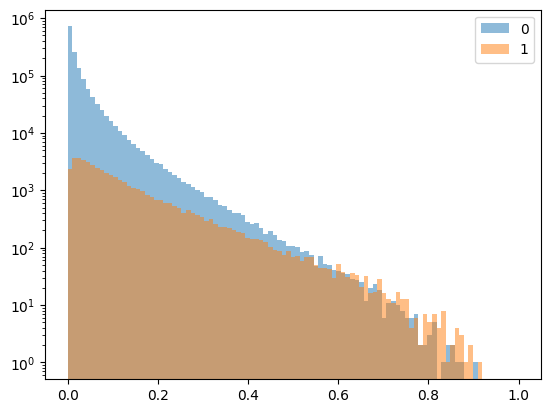

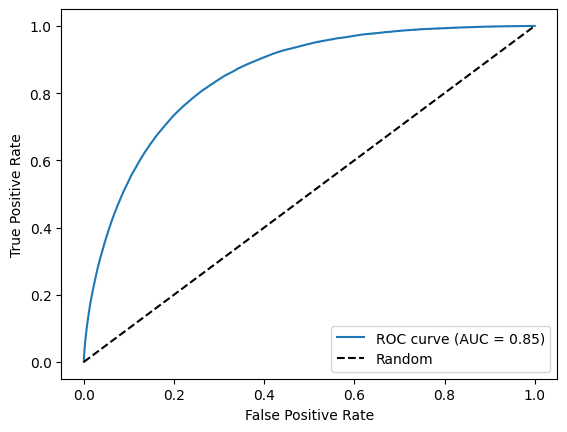

0.6837642754493195


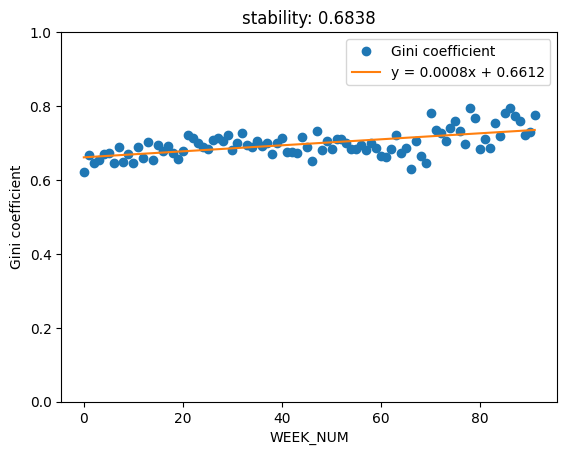

,WEEK_NUM,Gini
0,0,0.620409
1,1,0.668534
2,2,0.644718
3,3,0.653293
4,4,0.669600
...,...,...
87,87,0.771800
88,88,0.760076
89,89,0.721859
90,90,0.730787


0.6837642754493195

In [17]:
if MODE == 'train':
    study = optimize(X, y, cv=False)
    print(study.best_params)

    # retrain with the best params
    params.update(study.best_params)
    oof = train(X, y)
    df_gini_weeks, stability = evaluate(y, oof, y.index)
    display(df_gini_weeks)
    display(stability)

else:
    models = []
    for i in range(5):
        model_path = MODEL_DIR.joinpath(f'model_{i}.pkl')
        with open(model_path, 'rb') as model_path:
            model = pickle.load(model_path)
            models.append(model)
    submit = pd.read_csv(COMPETITION_DIR.joinpath('sample_submission.csv'))
    submit = predict(models, submit, X)
    submit.to_csv(Path('submission.csv'), index=False)
    display(submit)

In [7]:
# reload study from sql
study = optuna.load_study(
    study_name='lgbm-group-tune',
    storage=f'sqlite:///{MODEL_DIR}/study.db',
)

In [12]:
optuna.visualization.plot_optimization_history(study)

In [11]:
optuna.visualization.plot_param_importances(study)

In [13]:
optuna.visualization.plot_slice(study)

In [14]:
optuna.visualization.plot_parallel_coordinate(study)

In [17]:
optuna.visualization.plot_edf(study)